<a href="https://colab.research.google.com/github/Intelliled/HotDog-or-Not/blob/master/Copy_of_HotDogOr_Not_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image

from socket import timeout

from google.colab import files
#from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
#platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
#accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip3 install -q torch torchvision
!pip3 install -q Pillow==4.0.0

     |████████████████████████████████| 5.6MB 3.4MB/s 
ERROR: torchvision 0.3.0 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.15.0 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [0]:
# Download train data
!wget "https://www.dropbox.com/s/cupinvuotopehty/train.zip?dl=0"
!unzip -q "train.zip?dl=0"

#local_folder = "../../HotDogOrNot/content/train_kaggle/"

train_folder = "train_kaggle/"
# Count number of files in the train folder, should be 4603
print('Number of files in the train folder', len(os.listdir(train_folder)))

# Download test data
!wget "https://www.dropbox.com/s/7xakfl2r9gn5p1j/test.zip?dl=0"
!unzip -q "test.zip?dl=0"

test_folder = "test_kaggle/"
# Count number of files in the test folder, should be 1150
print('Number of files in the test folder', len(os.listdir(test_folder)))

--2019-07-31 19:56:05--  https://www.dropbox.com/s/cupinvuotopehty/train.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/cupinvuotopehty/train.zip [following]
--2019-07-31 19:56:05--  https://www.dropbox.com/s/raw/cupinvuotopehty/train.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc336ffad506225151f6a3616333.dl.dropboxusercontent.com/cd/0/inline/AlyfJX3T7iJeFKouyfCdOdPKF5rtK8OHuLFFYbRye6vN8ttJ2MzfbyDS39jvXUo77oDegaJpO-DrmgMPL-MrREO5pi9UBjo2_GyfXOWVc_03Wg/file# [following]
--2019-07-31 19:56:06--  https://uc336ffad506225151f6a3616333.dl.dropboxusercontent.com/cd/0/inline/AlyfJX3T7iJeFKouyfCdOdPKF5rtK8OHuLFFYbRye6vN8ttJ2MzfbyDS39jvXUo77oDegaJpO-DrmgMPL-MrREO5pi9UBjo2_GyfXOWVc_03Wg/file
Resolving uc336ffad5062

KeyboardInterrupt: ignored

In [0]:
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0") # Let's make sure GPU is available!

print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))
print(torch.cuda.max_memory_allocated(0))


0
Tesla T4
0


In [0]:
train_folder = "train_kaggle/"
print('Number of files in the train folder', len(os.listdir(train_folder)))
test_folder = "test_kaggle/"
print('Number of files in the test folder', len(os.listdir(test_folder)))

Number of files in the train folder 4603
Number of files in the test folder 1150


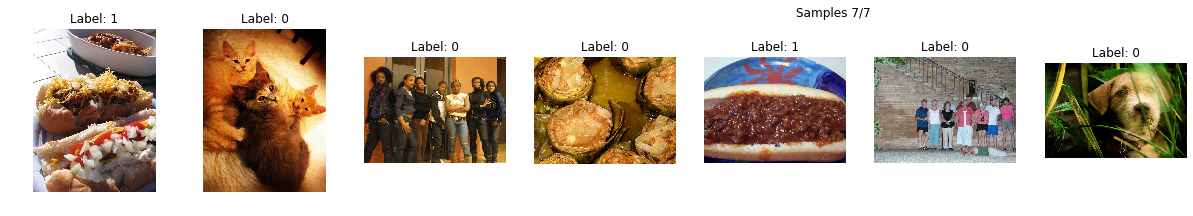

In [0]:
class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.folder = folder
        #print (self.transform)
        #self.self = transforms.Compose(transform)
        #self.self =transforms.Compose([transforms.RandomVerticalFlip(0.9)])
        composed = transforms.Compose(transform)
        
        # TODO: Your code here!
        
    def __len__(self):
        
        DIR = self.folder
        
        return len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])
    
    def __getitem__(self, index):        
        # TODO Implement getting item by index
        # Hint: os.path.join is helpful!
        #img_arr = np.arange(len(self.folder))
        #self.self = transforms.Compose(self.transform)
        #img_id = index
        file_name = os.listdir(self.folder)[index]
        img_id = file_name
        #print(file_name)
        img = Image.open(self.folder + file_name)
        #open(file_name, "rb", buffering=0)
        
        #print(file_name)
        #file_name = 'frankfurterchili-doghotdog12.jpg'
        flag  = file_name.find('frankfurter') and file_name.find('chili-dog') and file_name.find('hotdog')
        #print(flag)
        y = 1 if flag == 0 else 0
        
        
        if self.transform:
            img = self.transform(img)

               
        return img, y, img_id
        #return img, y

def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   
        
        
    
orig_dataset = HotdogOrNotDataset(train_folder)
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)
#indices
visualize_samples(orig_dataset, indices, "Samples")

In [0]:
train_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           #transforms.ColorJitter(hue=.20, saturation=.20),
                           transforms.RandomResizedCrop(224),
                           #transforms.RandomHorizontalFlip(0.7),
                           #transforms.RandomHorizontalFlip(0.7),
                           #transforms.RandomVerticalFlip(0.7),
                           #transforms.RandomRotation(50, resample=Image.BILINEAR),
                           transforms.CenterCrop(180),
                           #transforms.RandomVerticalFlip(0.5),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                         
                       ])
                      )

test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                          
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                         
                       ])
                      )

batch_size = 32
data_size = len(orig_dataset)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=10)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler, num_workers=10)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, num_workers=10)

In [0]:
def train_model(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        
        scheduler.step()
        print ('Current scheduler value is', exp_lr_scheduler.get_lr())
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        #or i_step, (x, y) in enumerate(train_loader):
        for i_step, (x, y,_) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        if val_accuracy > 0.972:
          print("Congrat! Accuracy more than 0.972!")
          return loss_history, train_history, val_history  
            
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    model.eval() # Evaluation mode
    correct_samples = 0
    total_samples = 0
    
    for i_step, (x, y, _) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
     
        prediction = model(x_gpu)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y.shape[0]
        val_accuracy = float(correct_samples) / total_samples
            
    return val_accuracy
    raise Exception("Not implemented")

In [0]:
def load_imagenet_classes():
    classes_json = urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read()
    classes = json.loads(classes_json)
    return { int(k): v[-1] for k, v in classes.items()}
   
resp_dict = load_imagenet_classes()

In [0]:
model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

#parameters = {lr: [1e-3, 1e-2]}  
# Fill the right thing here!
loss = nn.CrossEntropyLoss()
#optimizer = optim.SGD( parameters, lr=0.001, momentum=0.9)


#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.002, momentum=0.9, weight_decay=2, nesterov=True)
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
#optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0005)#, momentum=0.9, weight_decay=0.01)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0005, weight_decay=0.001, amsgrad=False, eps=1e-02, betas=[0.1, 0.9])#, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.25)

optimizer_ft

На 7 эпохе трейн акк = 1,000

In [0]:
from torch.optim import lr_scheduler

import torch.nn as nn
import torch.optim as optim

import sklearn.metrics as metrics
#Тренируем всю модель

model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

#parameters = {lr: [1e-3, 1e-2]}  
# Fill the right thing here!
loss = nn.CrossEntropyLoss()
#optimizer = optim.SGD( parameters, lr=0.001, momentum=0.9)


#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.002, momentum=0.9, weight_decay=2, nesterov=True)
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
#optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0005)#, momentum=0.9, weight_decay=0.01)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0005, weight_decay=0.001, amsgrad=False, eps=1e-02, betas=[0.1, 0.9])#, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.25)

optimizer_ft

Adam (
Parameter Group 0
    amsgrad: False
    betas: [0.1, 0.9]
    eps: 0.01
    initial_lr: 0.0005
    lr: 0.0005
    weight_decay: 0.001
)

In [0]:
loss_history, train_history, val_history = train_model(model_ft, train_loader, val_loader, loss, 
                                                       optimizer_ft, exp_lr_scheduler, 20)


Current scheduler value is [0.0005]


In [0]:
torch.cuda.empty_cache()